In [70]:
import numpy as np
import numpy.testing as npt
from scipy.linalg import expm
import matplotlib.pyplot as plt
import scipy.spatial, scipy.linalg
from scipy.spatial.distance import pdist
import scipy.sparse.linalg
from scipy.linalg import eigh
import zipfile,io
import pandas as pd
import zipfile
import re
import time
import numpy as np
import matplotlib.pyplot as plt
import time
import itertools as it
from matplotlib import cm
%matplotlib inline

# K-means Clustering

In this problem set we will implement and apply the standard (batch) K-means algorithm, the online version, and the “soft” clustering procedures. The file cluster.dat contains a data set of p = 500 (2-dimensional) observations generated from four different Gaussians with four different means.

## 9.1 K-means Clustering

Write a program that implements the standard version of K-means clustering and partitions the given data set into K clusters. Repeat the clustering procedure for different initializations of the prototypes and K = 2, 3, 4, 5, 6, 7, 8. Include the following steps:

### Initialization –

• Set the initial prototypes wq randomly around the data set mean

• Set the maximum number of iterations tmax, e.g. 5


In [71]:
dat=np.loadtxt("cluster.dat")

In [72]:
K = [2, 3, 4, 5, 6, 7, 8]
t_max= 5

### Optimization –

Implement the k-means update (see lecture notes). Each iteration should contain the following two steps

• assign all datapoints to their closest prototype

• re-compute the new positions of the prototypes for this assignment

In [73]:
def E(X,w,m):
    n=len(X[0])
    k = len(w[0])
    X2 = (X.T**2).sum(1).reshape(n,1)*np.ones((n,k))
    U2 = (w.T**2).sum(1).reshape(1,k) * np.ones([n,k])
    D = X2 - 2*(X.T.dot(w)) + U2
    return (D*m).sum()/(2*n)

def stdKmean(dat,K,t_max):
    Err = np.empty((len(K),t_max))
    n=len(dat[0])
    M = []
    W=[]
    k_ite=0
    for k in K:
        # Initializaton for each k
        w= np.random.randn(2,k)+np.mean(dat,1).reshape(2,1)
        X2 = (dat.T**2).sum(1).reshape(n,1)*np.ones((n,k))
        U2 = (w.T**2).sum(1).reshape(1,k) * np.ones([n,k])
        D = X2 - 2*(dat.T.dot(w)) + U2
        minidx= np.argmin(D,1)
        m = np.zeros((n,k))
        m[np.arange(n),minidx]=1
        W += [w]
        M += [m]
        for t in range(t_max):
            w = dat.dot(m)/m.sum(0)
            X2 = (dat.T**2).sum(1).reshape(n,1)*np.ones((n,k))
            U2 = (w.T**2).sum(1).reshape(1,k) * np.ones([n,k])
            D = X2 - 2*(dat.T.dot(w)) + U2
            minidx= np.argmin(D,1)
            m = np.zeros((n,k))
            m[np.arange(n),minidx]=1   
            M[k_ite]= m
            W[k_ite]= w
            Err[k_ite,t]=E(dat,w,m)
        k_ite +=1
    return M, W, Err
    

In [74]:
#optimization 
M,W,Err=stdKmean(dat,K,t_max)

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in true_divide


### Visualization –

(a) Visualize data points and prototypes for each iteration in a sequence of scatter plots.

(b) Plot the error function E against the iteration number t

(c) Create a plot (Voronoi-Tesselation) to show how the resulting solution assigns different regions of input space (e.g. new data points x 2 R2) to the different clusters.

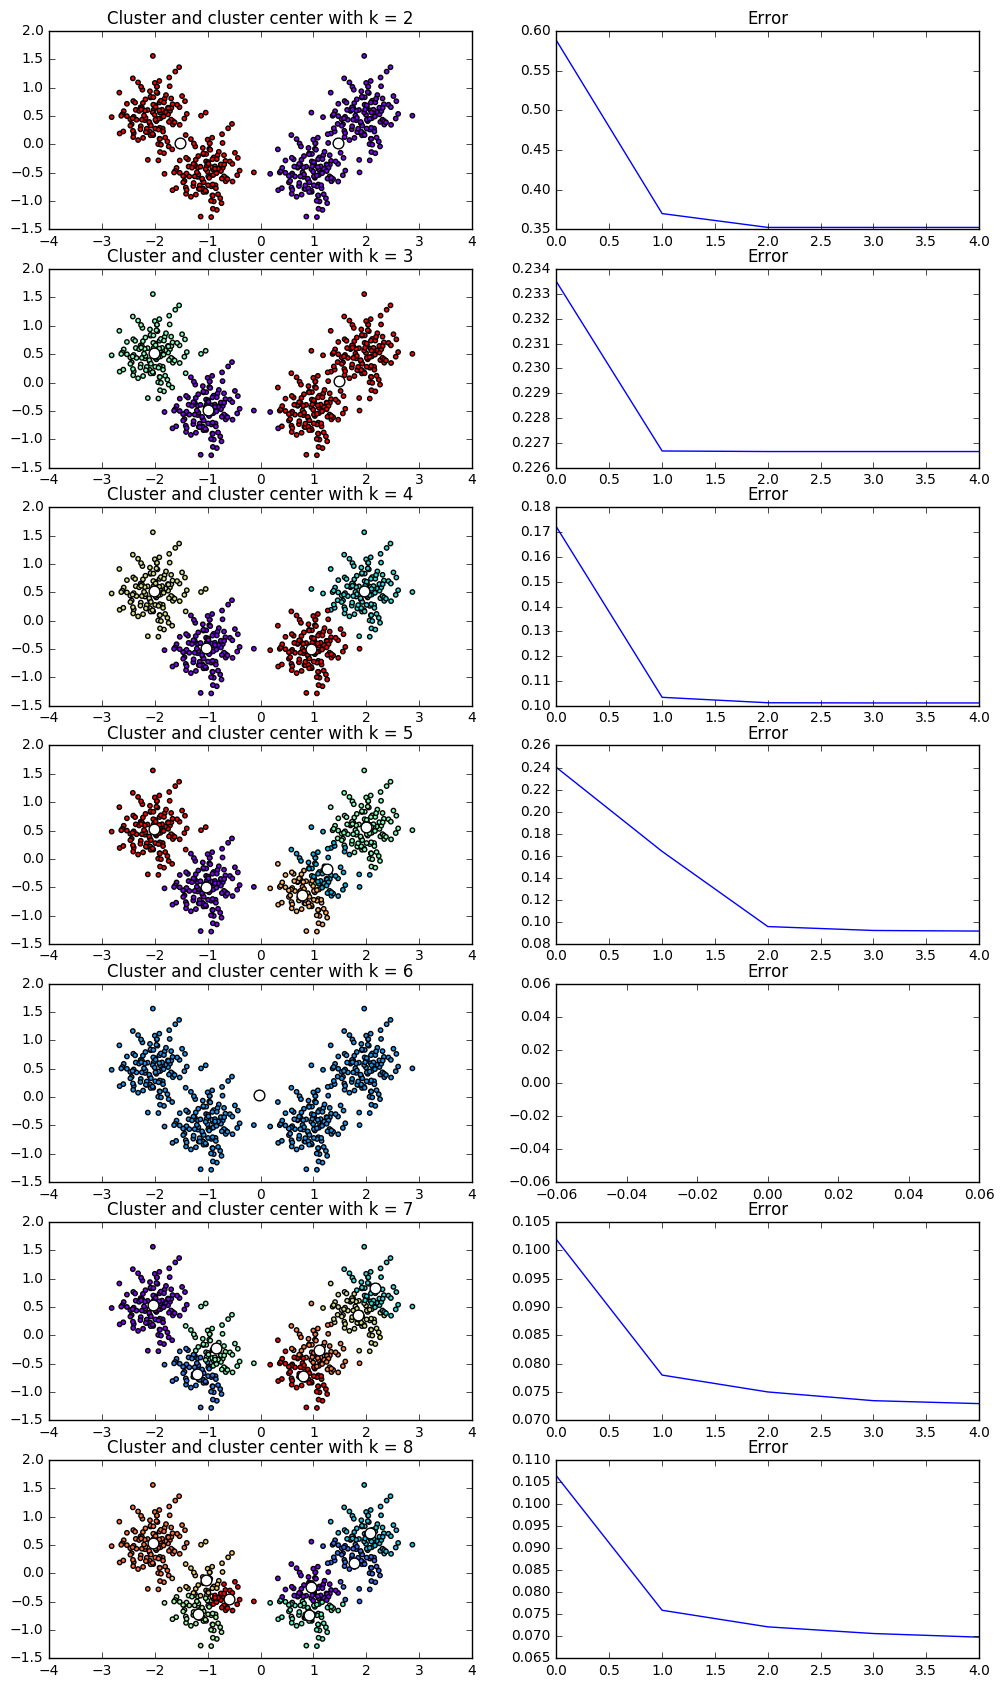

In [75]:
#plot
plt.figure(figsize=(12,21))
ite = 0
for k in K:
    colors = cm.rainbow(np.linspace(0, 1, k))
    category = np.dot(M[ite],colors)
    plt.subplot(7,2,2*ite+1)
    plt.scatter(dat[0],dat[1],10,category)
    plt.scatter(W[ite][0],W[ite][1], 60, c='white')
    plt.title('Cluster and cluster center with k = %i'%k )
    plt.subplot(7,2,2*ite+2)
    plt.plot(np.arange(t_max),Err[ite])
    plt.title('Error' )
    ite +=1

## 9.2 Online K-means Clustering

Write a program that implements the online version of K-means clustering (see lecture notes) and partitions the given data set into K = 4 clusters. Include the following steps:

### Initialization –

• Set the initial prototypes wq randomly around the data set mean

• Select an initial learning step $\epsilon_0$

• Set the maximum number of iterations tmax, e.g. equal to the data set size p.

In [154]:
dat=np.loadtxt("cluster.dat")

In [155]:
K = [4]
t_max= len(dat[0])

In [173]:
def E(X,w,m):
    n=len(X[0])
    k = len(w[0])
    X2 = (X.T**2).sum(1).reshape(n,1)*np.ones((n,k))
    U2 = (w.T**2).sum(1).reshape(1,k) * np.ones([n,k])
    D = X2 - 2*(X.T.dot(w)) + U2
    return (D*m).sum()/(2*n)

def onlKmean(dat,K,t_max,eps,tau):
    Err = np.empty((len(K),t_max))
    thres = t_max*0.25
    n=len(dat[0])
    d = len(dat)
    Line = []
    M = []
    M1 = []
    W=[]
    W1=[]
    k_ite=0
    for k in K:
        # Initializaton for each k
        w= np.random.randn(d,k)+np.mean(dat,1).reshape(d,1)
        X2 = (dat.T**2).sum(1).reshape(n,1)*np.ones((n,k))
        U2 = (w.T**2).sum(1).reshape(1,k) * np.ones([n,k])
        D = X2 - 2*(dat.T.dot(w)) + U2
        minidx= np.argmin(D,1)
        m = np.zeros((n,k))
        m[np.arange(n),minidx]=1
        W1 += [np.array(w)]
        M1 += [np.array(m)]
        l = np.empty((t_max+1,d,k))
        for t in range(t_max):
            num = t%n
            l[t]=np.array(w)
            minidx=np.argmin(np.linalg.norm(w-dat[:,num].reshape(d,1),axis=0))
            dw=eps*(dat[:,num]-w[:,minidx])
            w[:,minidx] +=dw
            X2 = (dat.T**2).sum(1).reshape(n,1)*np.ones((n,k))
            U2 = (w.T**2).sum(1).reshape(1,k) * np.ones([n,k])
            D = X2 - 2*(dat.T.dot(w)) + U2
            minidx= np.argmin(D,1)
            m = np.zeros((n,k))
            m[np.arange(n),minidx]=1
            Err[k_ite,t]=E(dat,w,m)
            if(t>thres):
                eps = eps*tau
        l[t_max]=np.array(w)
        Line +=[l]
        W += [w]
        M += [m]
        k_ite +=1
    return M, W, M1, W1, Err,Line
    

### Optimization –

• Choose a suitable τ < 1 and implement online K-means clustering using the following "annealing" schedule for ":

In [174]:
eps = 0.4
tau = 0.99
M, W, M1, W1, Err,Line = onlKmean(dat,K,t_max,eps,tau)

### Visualization –

(a) Visualize data points and the prototypes for each iteration in a sequence of scatter plots, but only show the first, the final, and four intermediate iterations. In the final plot additionally show for each cluster the the sequence of centroid positions wq by connecting them with straight lines.

(b) Plot the error function E (as above) against the iteration number t

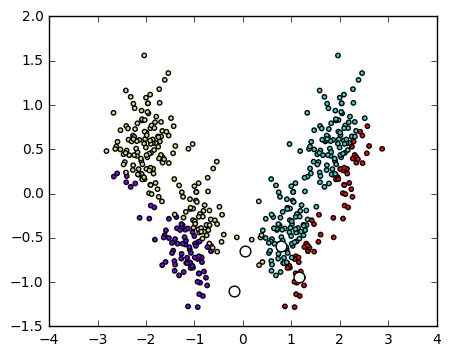

In [175]:
#plot 1st
plt.figure(figsize=(5,4))
ite = 0
for k in K:
    colors = cm.rainbow(np.linspace(0, 1, k))
    category = np.dot(M1[ite],colors)
    plt.subplot(1,1,ite+1)
    plt.scatter(dat[0],dat[1],10,category)
    plt.scatter(W1[ite][0],W1[ite][1], 60, c='white')
    ite +=1

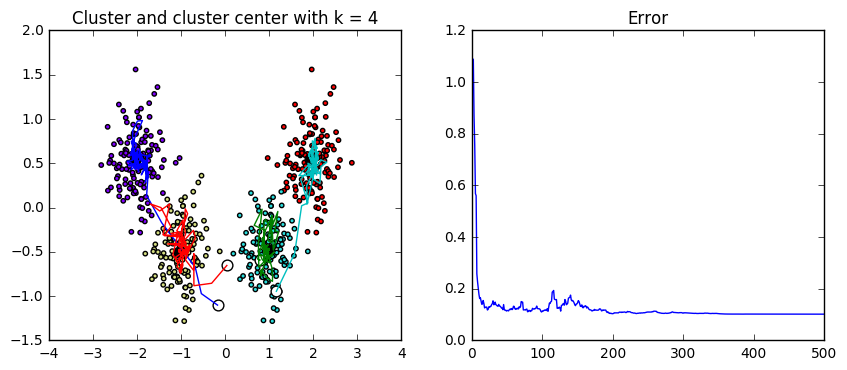

In [184]:
#plot final
plt.figure(figsize=(10,4))
ite = 0
for k in K:
    colors = cm.rainbow(np.linspace(0, 1, k))
    category = np.dot(M[ite],colors)
    plt.subplot(1,2,2*ite+1)
    plt.scatter(dat[0],dat[1],10,category)
    plt.scatter(W[ite][0],W[ite][1], 60, c='black')
    plt.scatter(W1[ite][0],W1[ite][1], 60, c='white')
    for i in range(k):
        plt.plot(Line[ite][:,0,i],Line[ite][:,1,i])
    plt.title('Cluster and cluster center with k = %i'%k )
    plt.subplot(1,2,2*ite+2)
    plt.plot(np.arange(t_max),Err[ite])
    plt.title('Error' )
    ite +=1

## 9.3 Soft K-means Clustering 

“Soft” clustering is a mean-field approximation of pairwise clustering with squared Euclidean distances. Implement the soft K-means algorithm with squared Euclidean distances (cf. lecture notes) and apply it to the same data as before. Proceed as follows:

(a) Set K = 8 initial prototypes wq randomly around the data set mean and choose a convergence tolerance γ.

In [ ]:
dat=np.loadtxt("cluster.dat")
K=[8]
tol = 0.001